# Business Problem

**The Blocker Fraud Company**

    - Financial transactions' fraud detection specialized company.
    - The Blocker Fraud service ensures fraudulent transactions block.
    - Business Model: service's performance monetization.

**Expansion Strategy:**

    - The company receives 10% of each transaction value truly detected as fraud. 
    - The company gives back 100% of the value for the customer in each transaction detected as legitimate, however the transaction is actually a fraud.

**Goal:**

    - Create a model with high accuracy and precision with respect to transactions' fraud detection.

**Deliverables:**

    - Model performance and results report with respect to profit and loss. The following questions must be answered:
        - What is the model's reliability with respect to transactions' classification as legitimate or fraudulent?
        - What is the Blocker Fraud Company forecasted profit using the model?
        
        

# 0.0 Imports

In [1]:
# data manipulation
import pandas as pd
import numpy as np
import random

# text edit 
import inflection

# graphs
import seaborn  as sns
from matplotlib import pyplot as plt

# warnings
import warnings
warnings.filterwarnings("ignore")

# load images and notebook display
from IPython.display      import Image
from IPython.core.display import HTML

# statistics
from scipy      import stats           as ss

# univariate analysis
from pandas_profiling     import ProfileReport 

# scalers
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder

# save files
import pickle

# models' cross-validation
from sklearn.model_selection import cross_validate, cross_val_score, cross_val_predict, RandomizedSearchCV, train_test_split

# Machine Learning models
from sklearn.ensemble     import RandomForestClassifier, RandomForestRegressor, IsolationForest
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors    import KNeighborsClassifier
from xgboost              import XGBClassifier

# models' metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, matthews_corrcoef
from scikitplot import metrics as mt


# 0.1 Helper Functions


In [2]:
def jupyter_settings():
    %matplotlib inline
    
    plt.style.use('bmh')
    plt.rcParams ['figure.figsize'] = [16,8]
    plt.rcParams ['font.size'] = 12
    
    sns.set()
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    pd.options.display.float_format = '{:.4f}'.format
       
    
def numerical_stats(num_attributes):
    
    # central tendency - mean, median
    c1 = pd.DataFrame(num_attributes.apply(np.mean)).T
    c2 = pd.DataFrame(num_attributes.apply(np.median)).T

    # dispersions - std, min, max, range, skew, kurtosis
    d1 = pd.DataFrame(num_attributes.apply(np.std)).T
    d2 = pd.DataFrame(num_attributes.apply(np.min)).T
    d3 = pd.DataFrame(num_attributes.apply(np.max)).T
    d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
    d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
    d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

    # concatenate
    n_s = pd.concat([d2, d3, d4, c1, c2, d1, d5, d6], axis=0).T.reset_index()
    n_s.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis' ]

    return n_s    


# performance du baseline model
def bm_performance(y_train,yhat_random):
    scores = {'accuracy': accuracy_score(y_train,yhat_random),
               'precision': precision_score(y_train,yhat_random),
               'recall': recall_score(y_train,yhat_random),
               'f1_score': f1_score(y_train,yhat_random),
               'roc_auc_score': roc_auc_score(y_train,yhat_random),
               'mcc': matthews_corrcoef(y_train,yhat_random)}

    # performance data frame
    bm_performance = pd.DataFrame(scores, index=[0])
    
    return bm_performance


def performance(model, x_train, y_train, cv):
    
    # calculate yhat 
    yhat = cross_val_predict(model, x_train, y_train, cv=cv)
    
    # defining metrics
    scores = {'accuracy': accuracy_score(y_train,yhat),
               'precision': precision_score(y_train,yhat),
               'recall': recall_score(y_train,yhat),
               'f1_score': f1_score(y_train,yhat),
               'roc_auc_score': roc_auc_score(y_train,yhat),
               'mcc': matthews_corrcoef(y_train,yhat)}
        
    results = pd.DataFrame(scores, index=[0])   
        
    return results, yhat
    

In [3]:
jupyter_settings()

# 0.2 Loading Data


In [4]:
# load dataset
df_raw = pd.read_csv('datasets/trans_fraud_data.csv', low_memory=True)
df_raw.sample(10)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
415046,18,PAYMENT,3449.4900,C5829020,50100.0000,46650.5100,M1075573654,0.0000,0.0000,0,0
4354012,309,CASH_IN,210284.5500,C1648587208,840.0000,211124.5500,C1323799276,1310867.7300,1100583.1900,0,0
4427435,322,CASH_IN,241991.7500,C700310051,217767.0000,459758.7500,C1170596580,640148.1300,398156.3800,0,0
2002282,179,PAYMENT,1431.1100,C113934590,375773.9400,374342.8300,M2130269858,0.0000,0.0000,0,0
2353054,189,PAYMENT,2250.1100,C796962372,41722.0000,39471.8900,M1245215277,0.0000,0.0000,0,0
5213165,370,PAYMENT,16582.1800,C398447355,0.0000,0.0000,M1069855607,0.0000,0.0000,0,0
6330985,690,PAYMENT,14508.4800,C2097661056,0.0000,0.0000,M2018780379,0.0000,0.0000,0,0
2752572,212,CASH_OUT,27311.9100,C283064251,64812.0000,37500.0900,C1466534828,0.0000,27311.9100,0,0
4299181,307,CASH_IN,235653.4700,C883562193,4819118.8300,5054772.3000,C224308862,3823709.1400,3588055.6700,0,0
3341498,253,PAYMENT,59515.6600,C151115229,854125.0000,794609.3400,M2009457296,0.0000,0.0000,0,0


In [5]:
# check data infos
df_raw.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   step            6362620 non-null  int64  
 1   type            6362620 non-null  object 
 2   amount          6362620 non-null  float64
 3   nameOrig        6362620 non-null  object 
 4   oldbalanceOrg   6362620 non-null  float64
 5   newbalanceOrig  6362620 non-null  float64
 6   nameDest        6362620 non-null  object 
 7   oldbalanceDest  6362620 non-null  float64
 8   newbalanceDest  6362620 non-null  float64
 9   isFraud         6362620 non-null  int64  
 10  isFlaggedFraud  6362620 non-null  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [6]:
# check isFraud proportion
df_raw['isFraud'].value_counts(normalize=True)

0   0.9987
1   0.0013
Name: isFraud, dtype: float64

In [7]:
# check Type proportion
df_raw['type'].value_counts(normalize=True)

CASH_OUT   0.3517
PAYMENT    0.3381
CASH_IN    0.2199
TRANSFER   0.0838
DEBIT      0.0065
Name: type, dtype: float64

# 1.0 Data Description

In [8]:
df1 = df_raw.copy()

**step** - maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).

**type** - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.

**amount** - amount of the transaction in local currency.

**nameOrig** - customer who started the transaction

**oldbalanceOrg** - initial balance before the transaction

**newbalanceOrig** - new balance after the transaction

**nameDest** - customer who is the recipient of the transaction

**oldbalanceDest** - initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).

**newbalanceDest** - new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).

**isFraud** - This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.

**isFlaggedFraud** - The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.

## 1.1 Rename columns

In [9]:
cols_old = df1.columns
cols_old

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')

In [10]:
# apply snakecase to columns name
snakecase = lambda x: inflection.underscore(x)
cols_new = list(map(snakecase, cols_old))

# rename columns
df1.columns = cols_new

cols_new

['step',
 'type',
 'amount',
 'name_orig',
 'oldbalance_org',
 'newbalance_orig',
 'name_dest',
 'oldbalance_dest',
 'newbalance_dest',
 'is_fraud',
 'is_flagged_fraud']

## 1.2 Data Type

In [11]:
df1.dtypes

step                  int64
type                 object
amount              float64
name_orig            object
oldbalance_org      float64
newbalance_orig     float64
name_dest            object
oldbalance_dest     float64
newbalance_dest     float64
is_fraud              int64
is_flagged_fraud      int64
dtype: object

## 1.3 NA Check

In [12]:
df1.isna().sum()

step                0
type                0
amount              0
name_orig           0
oldbalance_org      0
newbalance_orig     0
name_dest           0
oldbalance_dest     0
newbalance_dest     0
is_fraud            0
is_flagged_fraud    0
dtype: int64

## 1.4 Descriptive Analysis

In [13]:
# select numerical attributes
num_attributes = df1.select_dtypes(include=['int64', 'float64'])

# select categorical attributes
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64'])

### 1.4.1 Numerical 

In [14]:
# describe numerical attributes
numerical_stats(num_attributes)

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,step,1.0000,743.0000,742.0000,243.3972,239.0000,142.3320,0.3752,0.3291
1,amount,0.0000,92445516.6400,92445516.6400,179861.9035,74871.9400,603858.1840,30.9939,1797.9567
2,oldbalance_org,0.0000,59585040.3700,59585040.3700,833883.1041,14208.0000,2888242.4460,5.2491,32.9649
3,newbalance_orig,0.0000,49585040.3700,49585040.3700,855113.6686,0.0000,2924048.2732,5.1769,32.0670
4,oldbalance_dest,0.0000,356015889.3500,356015889.3500,1100701.6665,132705.6650,3399179.8458,19.9218,948.6741
5,newbalance_dest,0.0000,356179278.9200,356179278.9200,1224996.3982,214661.4400,3674128.6534,19.3523,862.1565
6,is_fraud,0.0000,1.0000,1.0000,0.0013,0.0000,0.0359,27.7795,769.7030
7,is_flagged_fraud,0.0000,1.0000,1.0000,0.0000,0.0000,0.0016,630.6036,397659.0625


In [15]:
# check amount of is_fraud transations
df1['is_fraud'].value_counts()

0    6354407
1       8213
Name: is_fraud, dtype: int64

In [16]:
# check amount of is_flagged_fraud transations
df1['is_flagged_fraud'].value_counts()

0    6362604
1         16
Name: is_flagged_fraud, dtype: int64

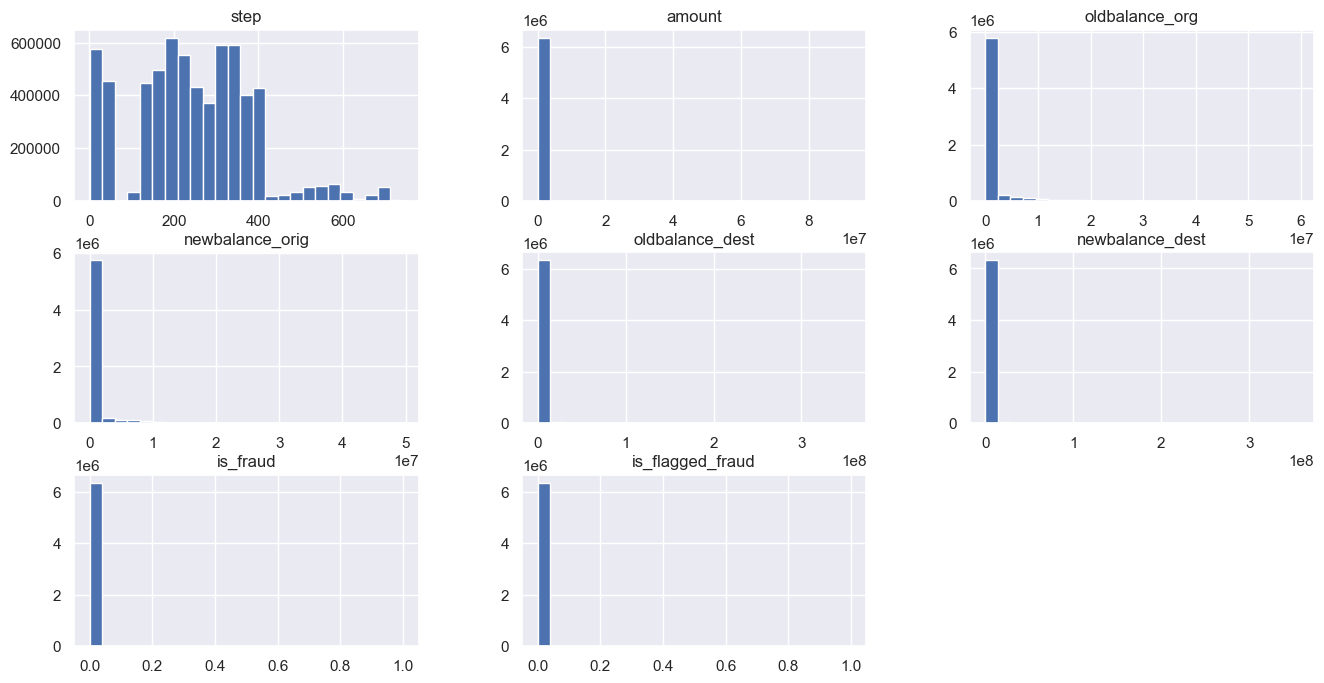

In [17]:
num_attributes.hist(bins=25);

- Between steps 50 and 75 (day 2 and day 3) seems that there are few / not transactions;
- After step 400 (day 17) the frequency of transactions decreases significantly.

### 1.6.3 Categorical 

In [18]:
cat_attributes.describe()

,type,name_orig,name_dest
count,6362620,6362620,6362620
unique,5,6353307,2722362
top,CASH_OUT,C1902386530,C1286084959
freq,2237500,3,113


In [19]:
# check type feature
type_feat = cat_attributes['type'].value_counts()
type_feat

CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: type, dtype: int64

In [20]:
dic = {}
for k, v in type_feat.items():
    dic[k] = v / len(cat_attributes) *100

type_feat_perc = pd.DataFrame(dic, index=['percentage_%']).T

type_feat_perc

,percentage_%
CASH_OUT,35.1663
PAYMENT,33.8146
CASH_IN,21.9923
TRANSFER,8.3756
DEBIT,0.6512


In [21]:
df1.to_csv('datasets/df1.csv', index=False)

# 2.0 Feature Engineering

In [22]:
df2 = pd.read_csv('datasets/df1.csv')

## 2.1 Hyphotesis

**H1** - Fraud should occur for high transaction amount

**H2** - Transfer fraud represents more than 70% of fraudulent transactions

**H3** - Fraud should occur when the origin balance difference before and after the transaction differs from the transaction amount

**H4** - Fraud should occur when origin balance after the transaction is equal to zero in more than 80% of fraudulent transactions

**H5** -  Fraud should occur when the recipient balance before the transaction is equal to zero in more than 80% of the fraudulent transactions.

**H6** - Fraud should occur when the recipient balance difference before and after the transaction is different from the transaction amount.

**H7** - Fraud should not occur for merchant customer as recipient

**H8** - Fraud should occur for customers that receive the transaction with more frequency.

**H9** - Frauds should be homogeneous over time.

**H10** - All the transactions flagged as fraud should be fraud

## 2.2 Create New Features

In [23]:
# difference beteween the amount and origin balance difference before and after the transaction
df2['diff_org_balance'] = (df2['oldbalance_org'] - df2['newbalance_orig'] - df2['amount']).astype(np.int64)

# difference beteween the amount and destination balance difference before and after the transaction
df2['diff_dest_balance'] = (df2['oldbalance_dest'] - df2['newbalance_dest'] - df2['amount']).astype(np.int64)

# create a column to differentiate merchants customers
df2['merchant_dest'] = df2.apply(lambda x: 1 if 'M' in x['name_dest'] else 0, axis=1)

# create a column with the tranformation of step into days
df2['day'] = df2.apply(lambda x: int(np.ceil(x['step']/24)), axis=1)



In [24]:
df2.head()

,step,type,amount,name_orig,oldbalance_org,newbalance_orig,name_dest,oldbalance_dest,newbalance_dest,is_fraud,is_flagged_fraud,diff_org_balance,diff_dest_balance,merchant_dest,day
0,1,PAYMENT,9839.6400,C1231006815,170136.0000,160296.3600,M1979787155,0.0000,0.0000,0,0,0,-9839,1,1
1,1,PAYMENT,1864.2800,C1666544295,21249.0000,19384.7200,M2044282225,0.0000,0.0000,0,0,0,-1864,1,1
2,1,TRANSFER,181.0000,C1305486145,181.0000,0.0000,C553264065,0.0000,0.0000,1,0,0,-181,0,1
3,1,CASH_OUT,181.0000,C840083671,181.0000,0.0000,C38997010,21182.0000,0.0000,1,0,0,21001,0,1
4,1,PAYMENT,11668.1400,C2048537720,41554.0000,29885.8600,M1230701703,0.0000,0.0000,0,0,0,-11668,1,1


In [25]:
df2.to_csv('datasets/df2.csv', index=False)

# 3.0 Data Filtering

## 3.1. Filtering Rows

## 3.2. Filtering Columns

# 4.0 Exploratory Data Analysis (EDA)

In [26]:
df4 = pd.read_csv('datasets/df2.csv')

## 4.1.1 Univariate Analysis 

In [27]:
profile = ProfileReport(df4)
profile.to_file('reports/univariate_analysis_V01.html')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

## 4.1.2 Bivariate Analysis 

### **H1** - Fraud should occur for high transaction amount

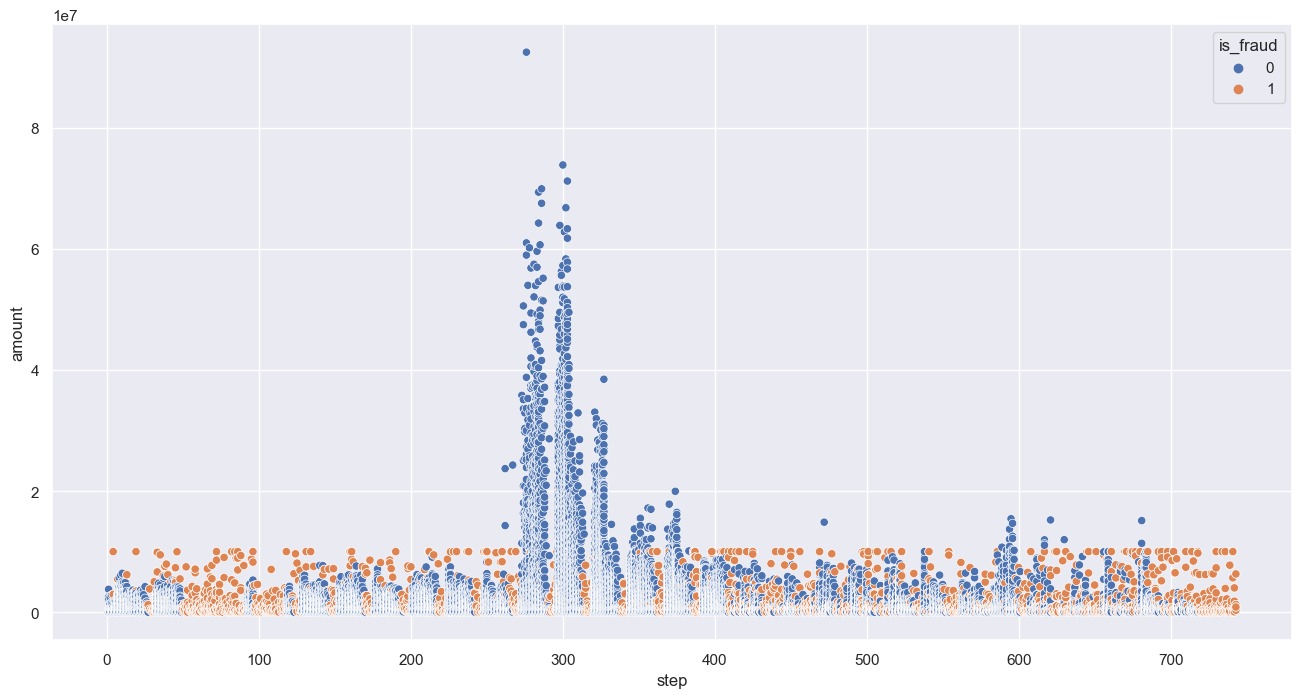

In [28]:
# plot amount scatter plot
sns.scatterplot(x='step', y='amount', hue='is_fraud', data=df4);

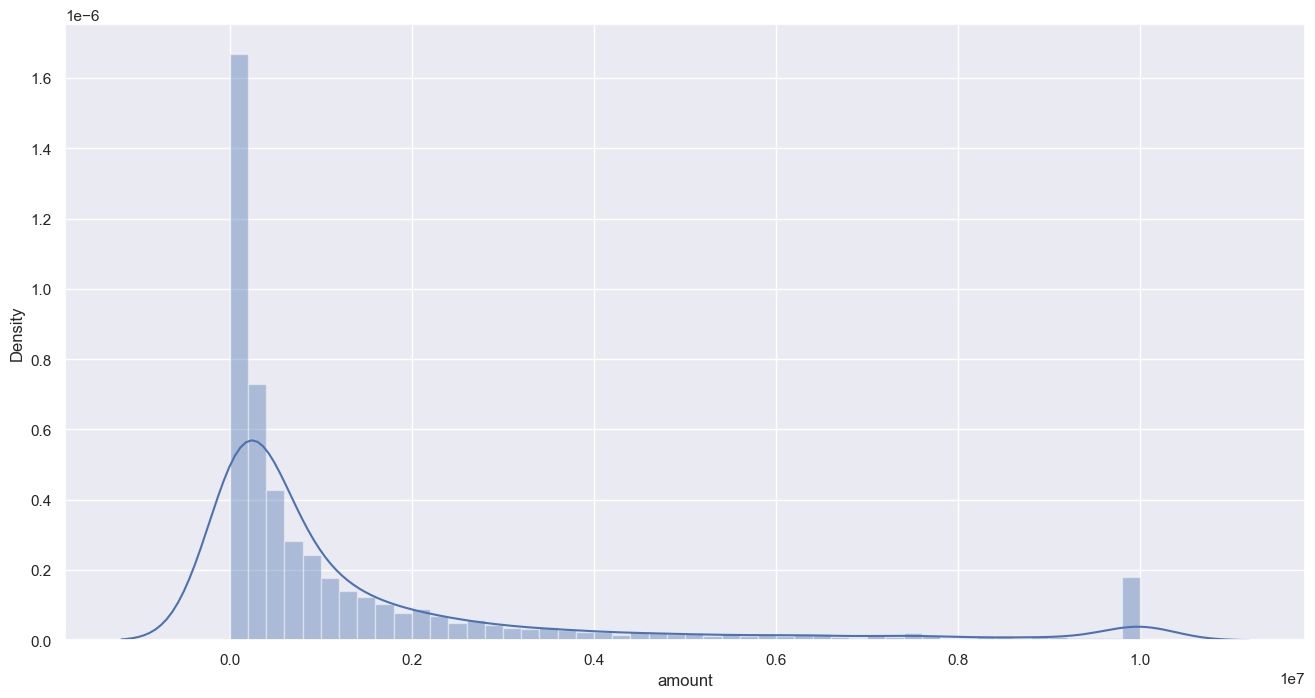

In [29]:
# filter only fraudulent transactions
h1 = df4[df4['is_fraud'] == 1]

# plot distribution
sns.distplot(h1['amount']);


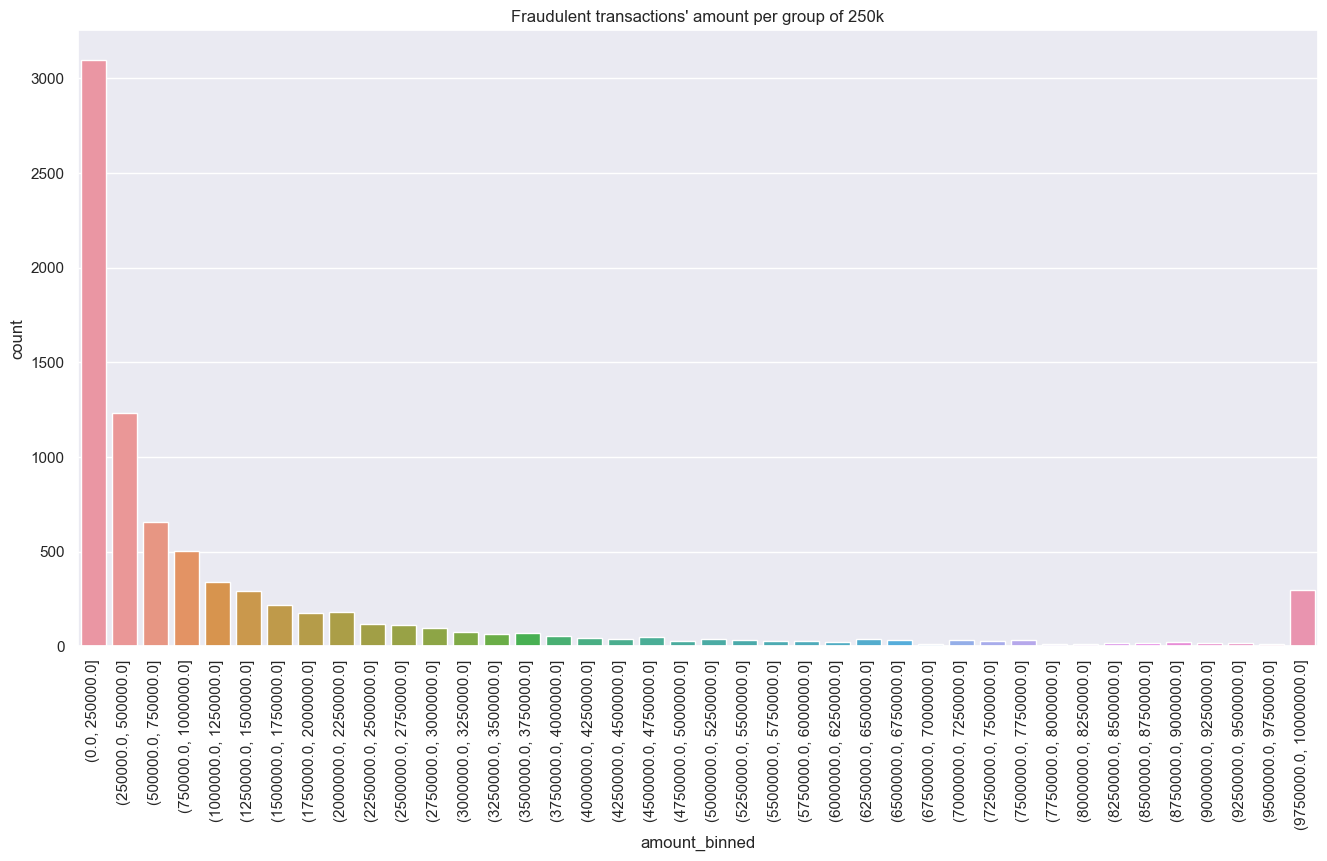

In [30]:
# plot amount binned values of fraudulent transactions
bins1 = list(np.arange(0, 10.1e6, 2.5e5))
h1['amount_binned'] = pd.cut(h1['amount'], bins=bins1)

sns.countplot(x='amount_binned', data=h1).set_title("Fraudulent transactions' amount per group of 250k");
# rotate x axis
plt.xticks(rotation=90);

- The concentration of fraudulent transactions is under 1 million, with the highest percentage under 250 thousands.
- There is not fraud transaction above transaction amount of 10 million

### **H2** - Transfer fraud represents more than 70% of fraudulent transactions

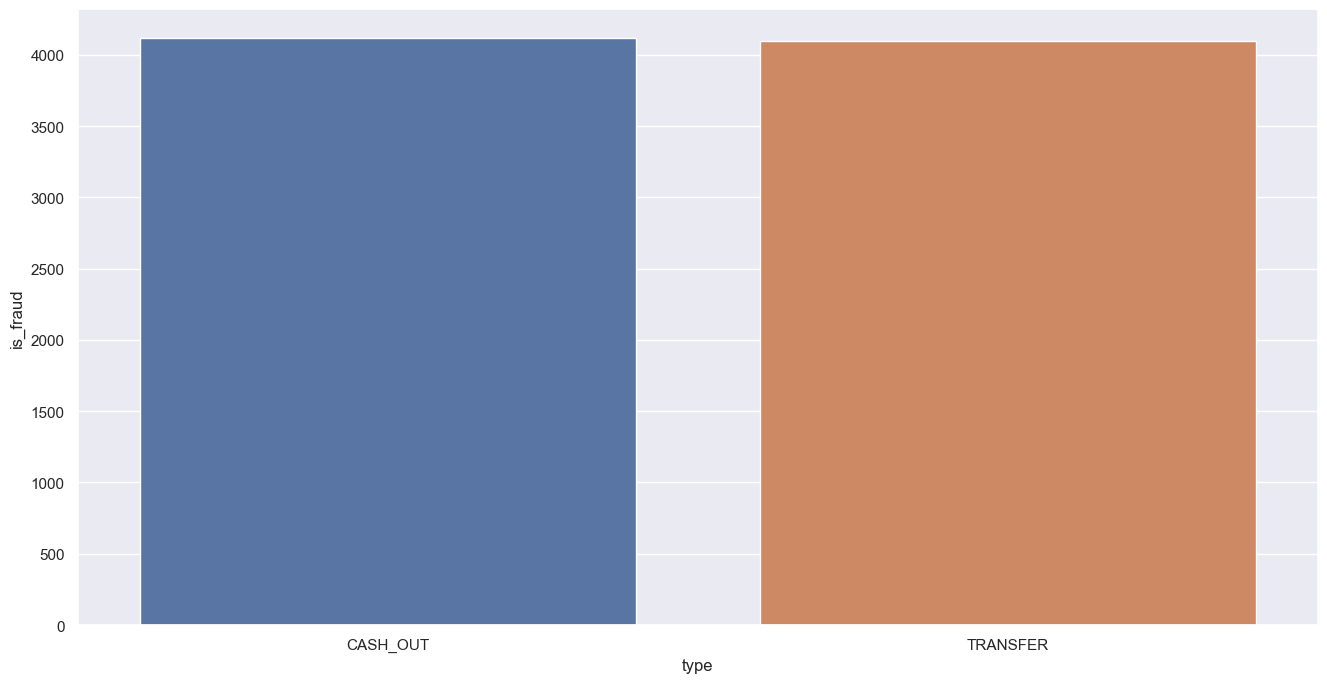

In [31]:
# filter only fraudulent transactions
h2 = df4[df4['is_fraud'] == 1]

# count how many fraudulent transaction there are of each type
h2 = h2.groupby('type')['is_fraud'].count().reset_index()

# plot the results
ax = sns.barplot(x='type', y='is_fraud', data=h2);

- The amount of transfer and cash out fraudulent transactions are almost the same

### **H3** - Fraud should occur when the origin balance difference before and after the transaction differs from the transaction amount

In [32]:
h3 = df4[df4['diff_org_balance'] != 0]

h3 = h3.groupby('is_fraud')['diff_org_balance'].count().reset_index().rename(columns={'diff_org_balance':'count_diff_org'})

h31 = df4.groupby('is_fraud')['diff_org_balance'].count().reset_index().rename(columns={'diff_org_balance':'count_total_org'})

h32 = pd.merge(h3, h31, on='is_fraud', how='left')

h32['percentage_%'] = h32['count_diff_org'] / h32['count_total_org'] * 100

h32


,is_fraud,count_diff_org,count_total_org,percentage_%
0,0,5000739,6354407,78.6972
1,1,45,8213,0.5479


- **False**. Only in 0.55% of the fraudulent transactions the origin balance difference before and after the transaction differs from the transaction amount

### **H4** - Fraud should occur when origin balance after the transaction is equal to zero in more than 80% of fraudulent transactions

In [33]:
h4 = df4[df4['newbalance_orig'] == float(0)].groupby('is_fraud')['newbalance_orig'].count().reset_index().rename(columns={'newbalance_orig':'count_org_0'})

h41 = df4.groupby('is_fraud')['newbalance_orig'].count().reset_index().rename(columns={'newbalance_orig':'count_org_diff0'})

h42 = pd.merge(h4, h41, on='is_fraud', how='left')

h42['percentage_%'] = h42['count_org_0'] / h42['count_org_diff0'] * 100

h42

,is_fraud,count_org_0,count_org_diff0,percentage_%
0,0,3601513,6354407,56.6774
1,1,8053,8213,98.0519


- In 98.05% of the fraudulent transactions the origin balance after the transaction is equal to zero

### **H5** -  Fraud should occur when the recipient balance before the transaction is equal to zero in more than 80% of the fraudulent transactions.

In [34]:
h5 = df4[df4['oldbalance_dest'] == float(0)].groupby('is_fraud')['oldbalance_dest'].count().reset_index().rename(columns={'oldbalance_dest':'count_dest_0'})

h51 = df4.groupby('is_fraud')['oldbalance_dest'].count().reset_index().rename(columns={'oldbalance_dest':'count_dest_diff0'})

h52 = pd.merge(h5, h51, on='is_fraud', how='left')

h52['percentage_%'] = h52['count_dest_0'] / h52['count_dest_diff0'] * 100

h52

,is_fraud,count_dest_0,count_dest_diff0,percentage_%
0,0,2699037,6354407,42.4750
1,1,5351,8213,65.1528


- **False** Only in 65.15% of the fraudulent transactions the recipient balance after the transaction is equal to zero

### **H6** - Fraud should occur when the recipient balance difference before and after the transaction is different from the transaction amount.

In [35]:
h6 = df4[df4['diff_dest_balance'] != 0]

h6 = h6.groupby('is_fraud')['diff_dest_balance'].count().reset_index().rename(columns={'diff_dest_balance':'count_diff_dest'})

h61 = df4.groupby('is_fraud')['diff_dest_balance'].count().reset_index().rename(columns={'diff_dest_balance':'count_total_dest'})

h62 = pd.merge(h6, h61, on='is_fraud', how='left')

h62['percentage_%'] = h62['count_diff_dest'] / h62['count_total_dest'] * 100

h62

,is_fraud,count_diff_dest,count_total_dest,percentage_%
0,0,5322255,6354407,83.7569
1,1,8197,8213,99.8052


- In almost all of the fraudulent transactions the recipient balance difference before and after the transaction differs from the transaction amount

### **H7** - Fraud should not occur for merchant customer as recipient

In [36]:
h7 = df4.groupby(['is_fraud','merchant_dest'])['type'].count().reset_index().rename(columns = {'type':'count'})

h7

,is_fraud,merchant_dest,count
0,0,0,4202912
1,0,1,2151495
2,1,0,8213


- No fraudulent transations that have merchant customer as recipient

### **H8** - Fraud should occur for customers that receive the transaction with more frequency.

In [37]:
h8 = df4.groupby('name_dest')['is_fraud'].sum().reset_index().sort_values('is_fraud', ascending=False)

h8.head()

,name_dest,is_fraud
108539,C1366192319,2
136628,C1460854172,2
57504,C1193568854,2
468311,C650699445,2
425624,C505532836,2


### **H9** - Frauds should be homogeneous over time.

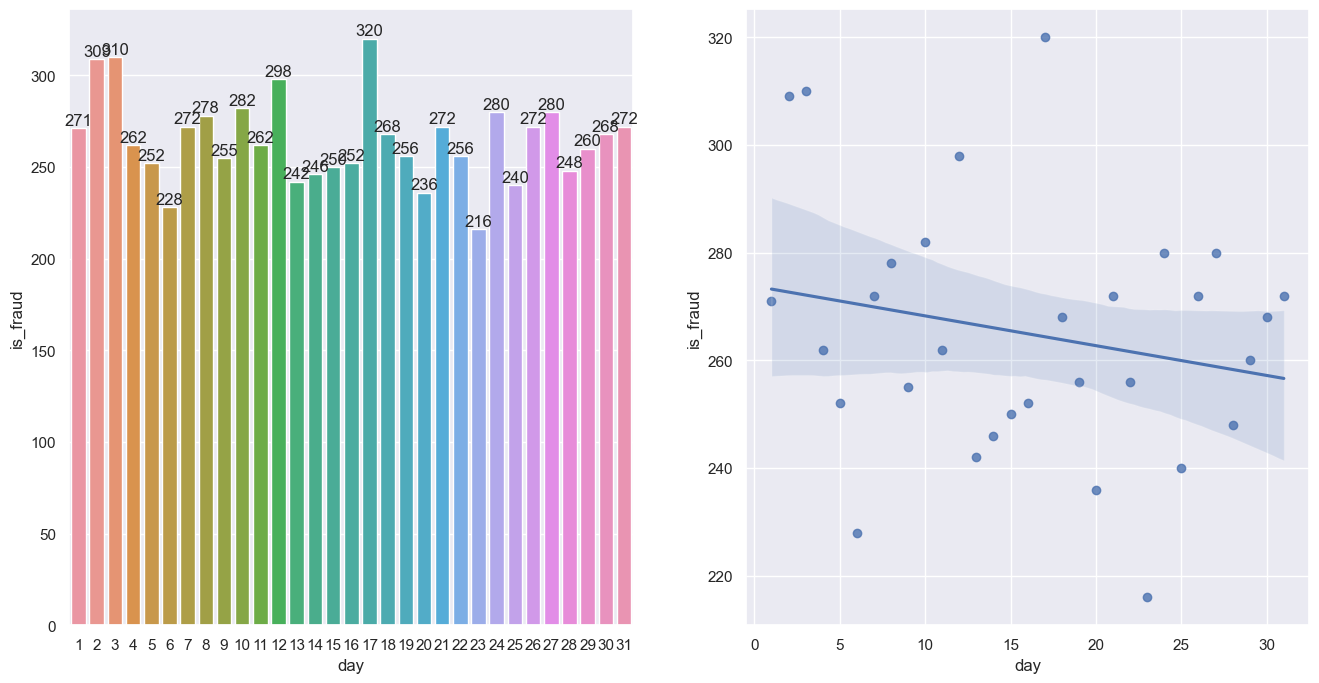

In [38]:
h9 = df4.groupby('day')['is_fraud'].sum().reset_index()

plt.subplot(1,2,1)
ax = sns.barplot(x='day' , y= 'is_fraud', data=h9);
ax.bar_label(ax.containers[0]);

plt.subplot(1,2,2)
sns.regplot(x='day', y='is_fraud', data=h9);

### **H10** - All the transactions flagged as fraud should be fraud

In [39]:
h10 = df4.groupby(['is_flagged_fraud','is_fraud'])['type'].count().reset_index().rename(columns = {'type':'count'})

h10

,is_flagged_fraud,is_fraud,count
0,0,0,6354407
1,0,1,8197
2,1,1,16


## 4.1.3 Multivariate Analysis 

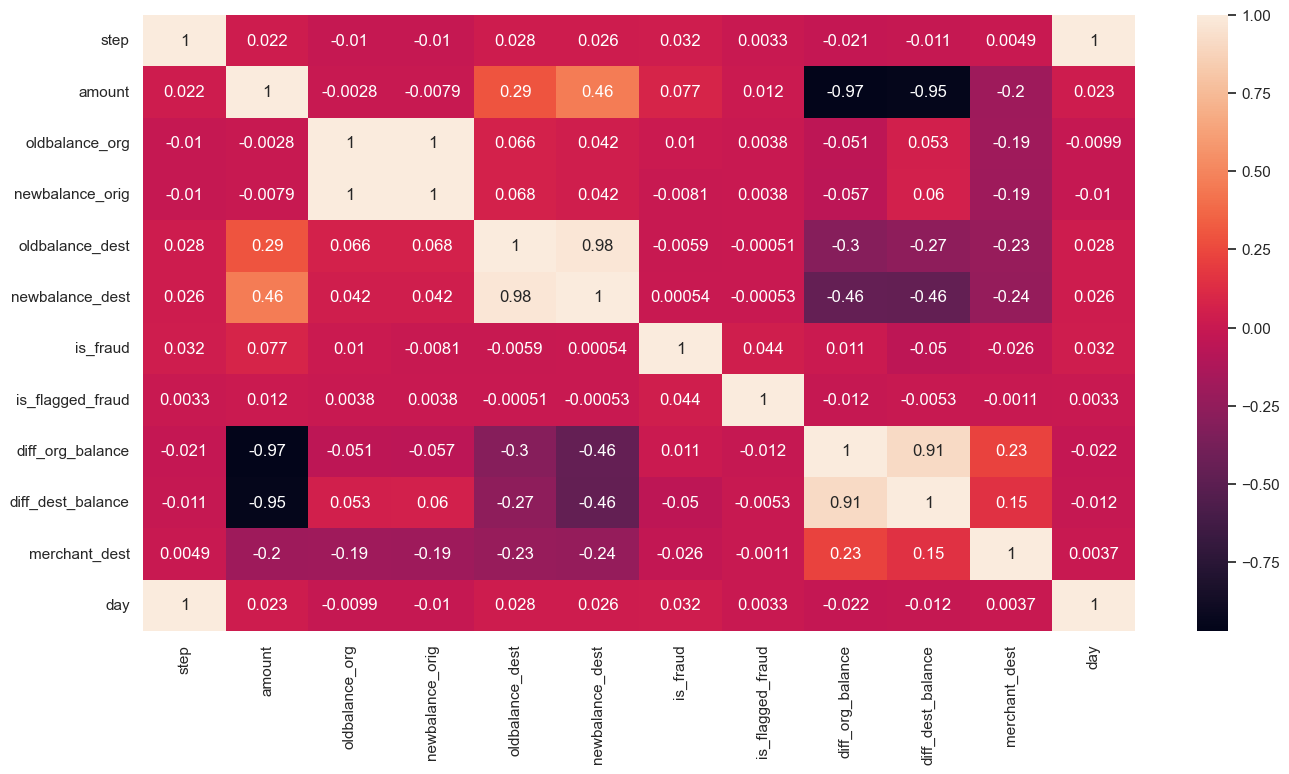

In [ ]:
# correlation betwenn numerical variables
num_attributes = df4.select_dtypes(include=['int64', 'float64'])
correlation = num_attributes.corr(method = 'pearson')
sns.heatmap (correlation, annot=True);

**Highest correlations:**
- step x day                           = 1 (day was created with step);
- newbalance_orig x oldbalance_org     = 1;
- diff_org_balance x amount            = -0.97;
- diff_dest_balance x amount           = -0.95;
- newbalance_dest x oldbalance_des     = 0,98;
- diff_dest_balance x diff_org_balance = 0.91



# <font color=''> 5.0 Data Preparation </font>

In [ ]:
df5 = pd.read_csv('datasets/df2.csv')

## <font color=''> 5.1 Rescaling </font>

In [ ]:
# 1. Robust Scaler - amount, oldbalance_org, newbalane_orig, oldbalance_dest, newbalance_dest, diff_org_balance, diff_dest_balance
rs = RobustScaler()

# amount
df5['amount'] = rs.fit_transform(df5[['amount']].values)
with open('parameter/amount_scaler.pkl', 'wb') as f:
    pickle.dump(rs, f)
    
# oldbalance_org
df5['oldbalance_org'] = rs.fit_transform(df5[['oldbalance_org']].values)
with open('parameter/oldbalance_org_scaler.pkl', 'wb') as f:
    pickle.dump(rs, f)
    
# newbalance_orig
df5['newbalance_orig'] = rs.fit_transform(df5[['newbalance_orig']].values)
with open('parameter/newbalance_orig_scaler.pkl', 'wb') as f:
    pickle.dump(rs, f)
       
# oldbalance_dest
df5['oldbalance_dest'] = rs.fit_transform(df5[['oldbalance_dest']].values)
with open('parameter/oldbalance_dest_scaler.pkl', 'wb') as f:
    pickle.dump(rs, f)
    
# newbalance_dest
df5['newbalance_dest'] = rs.fit_transform(df5[['newbalance_dest']].values)
with open('parameter/newbalance_dest_scaler.pkl', 'wb') as f:
    pickle.dump(rs, f)

# diff_org_balance
df5['diff_orig'] = rs.fit_transform(df5[['diff_org_balance']].values)
with open('parameter/diff_orig_scaler.pkl', 'wb') as f:
    pickle.dump(rs, f)    
    
# diff_dest_balance
df5['diff_dest'] = rs.fit_transform(df5[['diff_dest_balance']].values)
with open('parameter/diff_dest_scaler.pkl', 'wb') as f:
    pickle.dump(rs, f)

## <font color=''> 5.2 Encoding </font>

In [ ]:
# one hot encoding for type feature
df5 = pd.get_dummies(df5, prefix=['type'], columns=['type'])

## <font color=''> 5.3 Transformation </font>

In [ ]:
# apply nature transformation on day feature
df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * (2. * np.pi/31 ) ) )
df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x * (2. * np.pi/31 ) ) )

In [ ]:
df5.head()

In [ ]:
df5.to_csv('datasets/df5.csv', index=False)

# 6.0 Feature Selection

In [ ]:
df6 = pd.read_csv('datasets/df5.csv')

In [ ]:
# drop unnecessary columns
df6 = df6.drop(['step', 'name_orig','day','name_dest'], axis=1)

In [ ]:
X = df6.drop('is_fraud', axis=1)
y = df6['is_fraud']

## 6.1 Split dataframe into train and test dataset

In [ ]:
# Split dataset into training and test
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## 6.2 Random Forest as feature selector

In [ ]:
# train random forest classifier
rf = RandomForestClassifier(random_state=42)
rf.fit(x_train, y_train)

In [ ]:
# feature importance data frame
feat_imp = pd.DataFrame({'feature': x_train.columns,
                         'feature_importance': rf.feature_importances_}).sort_values('feature_importance', ascending=False).reset_index(drop=True)


# plot feature importance
sns.barplot(x='feature_importance', y='feature', data=feat_imp, orient='h', color='royalblue').set_title('Feature Importance');

In [ ]:
feat_imp['feature']

- Taking into account the results obtained, let's exclude the type_CASH_IN and type_DEBIT features.

In [ ]:
cols_selected = ['newbalance_orig', 
                 'newbalance_dest', 
                 'amount', 
                 'oldbalance_org', 
                 'diff_orig', 
                 'diff_org_balance', 
                 'diff_dest', 
                 'diff_dest_balance', 
                 'day_cos', 
                 'type_TRANSFER', 
                 'oldbalance_dest', 
                 'type_CASH_OUT', 
                 'day_sin', 
                 'merchant_dest', 
                 'type_PAYMENT', 
                 'is_flagged_fraud',
]



In [ ]:
X_train = x_train[cols_selected]
X_test = x_test[cols_selected]


In [ ]:
X_train.to_csv('datasets/X_train.csv', index=False)
y_train.to_csv('datasets/y_train.csv', index=False)
X_test.to_csv('datasets/X_test.csv', index=False)
y_test.to_csv('datasets/y_test.csv', index=False)

# 7.0 Machine Learning Model

In [ ]:
X_train = pd.read_csv('datasets/X_train.csv')
y_train = pd.read_csv('datasets/y_train.csv')


## 7.1 Baseline Model 

In [ ]:
# list of target values
is_fraud_list = df6['is_fraud'].drop_duplicates().sort_values().tolist()
# target dimension
k_num = y_train.shape[0]
# percentage (weight) of each target value
is_fraud_weights = df6['is_fraud'].value_counts(normalize=True).sort_index().tolist()
# random prediction taking into account the weight of each target value
yhat_random = random.choices(population=is_fraud_list, weights=is_fraud_weights, k=k_num)

### 7.1.1 BM performance

In [ ]:
# call the function of baseline model performance
baseline_model = bm_performance(y_train, yhat_random)

baseline_model

In [ ]:
# Confusion Matrix
mt.plot_confusion_matrix(y_train, yhat_random, normalize=False);

In [ ]:
baseline_model.to_csv('results_models/baseline_model.csv', index=False)

## 7.2 Random Forest Classifier

In [ ]:
# define the model
rfc = RandomForestClassifier(random_state=42)

# performance
rfc_model = performance(model=rfc, x_train=X_train, y_train=y_train, cv=5)

In [ ]:
results, yhat = rfc_model

In [ ]:
results

In [ ]:
# Confusion Matrix
mt.plot_confusion_matrix(y_train, yhat, normalize=False);

In [ ]:
results.to_csv('results_models/rfc_model.csv', index=False)

## 7.3 Logistic Regression

In [ ]:
# define the model
lr = LogisticRegression(random_state=42)

# performance
lr_model = performance(model=lr, x_train=X_train, y_train=y_train, cv=10)

In [ ]:
results, yhat = lr_model

In [ ]:
results

In [ ]:
# Confusion Matrix
mt.plot_confusion_matrix(y_train, yhat, normalize=False);

In [ ]:
results.to_csv('results_models/lr_model.csv', index=False)

## 7.4 Isolation Forest

In [ ]:
# define model
isofr = IsolationForest(max_samples=0.25, random_state=42, contamination=0.15, n_jobs=-1)

# predictions
yhat = cross_val_predict(isofr, X_train, cv=5)

In [ ]:
# transform predictions to 0 and 1 to be compatible with y_train
yhat = np.where(yhat==-1, 1, yhat-1)

In [ ]:
# define metrics 
scores = {'accuracy': accuracy_score(y_train,yhat),
          'precision': precision_score(y_train,yhat),
          'recall': recall_score(y_train,yhat),
          'f1_score': f1_score(y_train,yhat),
          'roc_auc_score': roc_auc_score(y_train,yhat),
          'mcc': matthews_corrcoef(y_train,yhat)}
        
results = pd.DataFrame(scores, index=[0])

In [ ]:
results

In [ ]:
# Confusion Matrix
mt.plot_confusion_matrix(y_train, yhat, normalize=False);

In [ ]:
results.to_csv('results_models/isofr_model.csv', index=False)

## 7.5 XGBoost Classifier

In [1]:
# define model
xgb_cl = XGBClassifier(random_state=42, n_jobs=-1)

# performance
xgb_model = performance(model=xgb_cl, x_train=X_train, y_train=y_train, cv=5)


NameError: name 'XGBClassifier' is not defined

In [ ]:
results, yhat = xgb_model

In [ ]:
results

In [ ]:
# Confusion Matrix
mt.plot_confusion_matrix(y_train, yhat, normalize=False);

In [ ]:
results.to_csv('results_models/xgb_model.csv', index=False)

## 7.6 K Nearest Neighbors (KNN)

In [ ]:
# define model
knn_cl = KNeighborsClassifier(n_jobs=-1)

# performance
knn_model = performance(model=knn_cl, x_train=X_train, y_train=y_train, cv=5)

In [ ]:
results, yhat = knn_model

In [ ]:
results

In [ ]:
# Confusion Matrix
mt.plot_confusion_matrix(y_train, yhat, normalize=False);

In [ ]:
results.to_csv('results_models/knn_model.csv', index=False)

## 7.6 Performance comparison

In [ ]:
baseline_model = pd.read_csv('results_models/baseline_model.csv')
lr_model = pd.read_csv('results_models/lr_model.csv')
rfc_model = pd.read_csv('results_models/rfc_model.csv')
isofr_model = pd.read_csv('results_models/isofr_model.csv')
xgb_model = pd.read_csv('results_models/xgb_model.csv')
knn_model = pd.read_csv('results_models/knn_model.csv')

perf_comp = pd.concat([baseline_model,lr_model,rfc_model,isofr_model,xgb_model,knn_model], axis=0)

# set index with model names
perf_comp['model'] = ['baseline_model','lr_model','rfc_model','isofr_model','xgb_model','knn_model']
perf_comp = perf_comp.set_index('model').reset_index()


In [ ]:
perf_comp

In [ ]:
perf_comp.to_csv('results_models/peformance_comparison.csv', index=False)

# 8 Hyperparameter Fine Tuning

## 8.1 Random Search

In [ ]:
## define the model
rfc = RandomForestClassifier(random_state=42, n_jobs=-1)


In [ ]:
# define the grid
param_grid = {'n_estimators': np.arange(100, 500, 50),
              'max_depth': np.arange(2, 10, 1)}


In [ ]:
# prepares RandomizedSearchCV object
rfc_cv = RandomizedSearchCV(estimator=rfc, param_distributions=param_grid, scoring='f1', n_iter=10, cv=3, verbose=1, random_state=42, n_jobs=-1)

In [ ]:
# fit the model
rfc_cv.fit(X_train, y_train)


In [ ]:
# best estimator
rfc_tuned_model = rfc_cv.best_estimator_
rfc_tuned_model

## 8.2 Model Performance


### 8.2.1 Train dataset

In [ ]:
# model definition
rfc = RandomForestClassifier(random_state=42, n_estimators=300, max_depth=8, n_jobs=-1)

# training model
rfc.fit(X_train, y_train)

# prediction
yhat_train = rfc.predict(X_train)
        
# metrics
scores_train = {'accuracy': [],
          'precision': [],
          'recall': [],
          'f1_score': [],
          'roc_auc_score': [],
          'mcc': []}

scores_train['accuracy'] = accuracy_score(y_train,yhat_train)
scores_train['precision'] = precision_score(y_train,yhat_train) 
scores_train['recall'] = recall_score(y_train,yhat_train)
scores_train['f1_score'] = f1_score(y_train,yhat_train)
scores_train['roc_auc_score'] = roc_auc_score(y_train,yhat_train)
scores_train['mcc'] = matthews_corrcoef(y_train,yhat_train)  
    

In [ ]:
performance_train = pd.DataFrame(scores_train, index=[0])
performance_train

In [ ]:
# Confusion Matrix
mt.plot_confusion_matrix(y_train, yhat_train, normalize=False);

In [ ]:
# save tuned model
pickle.dump(rfc, open('model/model_rfc.pkl', 'wb'))

In [ ]:
# join prediction on the trainset
X_train['predictions'] = yhat_train
X_train.to_csv('datasets/X_train_predictions.csv', index=False)

### 8.2.2 Test dataset

In [ ]:
X_test = pd.read_csv('datasets/X_test.csv')
y_test = pd.read_csv('datasets/y_test.csv')

In [ ]:
# prediction
yhat_test = rfc.predict(X_test)
        
# metrics
scores_test = {'accuracy': [],
          'precision': [],
          'recall': [],
          'f1_score': [],
          'roc_auc_score': [],
          'mcc': []}

scores_test['accuracy'] = accuracy_score(y_test,yhat_test)
scores_test['precision'] = precision_score(y_test,yhat_test) 
scores_test['recall'] = recall_score(y_test,yhat_test)
scores_test['f1_score'] = f1_score(y_test,yhat_test)
scores_test['roc_auc_score'] = roc_auc_score(y_test,yhat_test)
scores_test['mcc'] = matthews_corrcoef(y_test,yhat_test)  

In [ ]:
performance_test = pd.DataFrame(scores_test, index=[0])
performance_test

In [ ]:
# Confusion Matrix
mt.plot_confusion_matrix(y_test, yhat_test, normalize=False);

In [ ]:
# join prediction on the testset
X_test['predictions'] = yhat_test
X_test.to_csv('datasets/X_test_predictions.csv', index=False)

### 8.2.3 On 100% of the transactions

In [ ]:
# dataset prepared
df6 = pd.read_csv('datasets/df5.csv')

# columns selected
cols_selected = ['newbalance_orig', 
                 'newbalance_dest', 
                 'amount', 
                 'oldbalance_org', 
                 'diff_orig', 
                 'diff_org_balance', 
                 'diff_dest', 
                 'diff_dest_balance', 
                 'day_cos', 
                 'type_TRANSFER', 
                 'oldbalance_dest', 
                 'type_CASH_OUT', 
                 'day_sin', 
                 'merchant_dest', 
                 'type_PAYMENT', 
                 'is_flagged_fraud',
]

# split features and target
X = df6[cols_selected]
y = df6['is_fraud']

In [ ]:
# prediction
yhat_raw = rfc.predict(X)
        
# metrics
scores = {'accuracy': [],
          'precision': [],
          'recall': [],
          'f1_score': [],
          'roc_auc_score': [],
          'mcc': []}

scores['accuracy'] = accuracy_score(y,yhat_raw)
scores['precision'] = precision_score(y,yhat_raw) 
scores['recall'] = recall_score(y,yhat_raw)
scores['f1_score'] = f1_score(y,yhat_raw)
scores['roc_auc_score'] = roc_auc_score(y,yhat_raw)
scores['mcc'] = matthews_corrcoef(y,yhat_raw)  

In [ ]:
performance = pd.DataFrame(scores, index=[0])
performance

In [ ]:
# Confusion Matrix
mt.plot_confusion_matrix(y, yhat_raw, normalize=False);

In [ ]:
# join prediction on the testset
df6['predictions'] = yhat_raw
df6.to_csv('datasets/df6_predictions.csv', index=False)


The model has good precision and good recall. The precision metric presents better results than the recall metric, but in this type of problem it will be better to focus on reducing false negatives (improving the recall metric).

# 9 Business Performance - Test dataset

In [ ]:
df6 = pd.read_csv('datasets/df6_predictions.csv')
df1 = pd.read_csv('datasets/df1.csv')

In [ ]:
df9 = pd.concat([df1, df6['predictions']], axis=1)

In [ ]:
df9.head()

In [ ]:
# The company receives 10% of the value of each transaction that is truly detected as fraud and returns 100% of the value of transactions that are detected as legitimate but are actually fraudulent.

df9_fraud = df9[['is_fraud', 'predictions', 'amount']].groupby(['is_fraud','predictions']).sum().reset_index()
df9_fraud

In [ ]:
df9_profit = df9_fraud.loc[3,'amount'] * 0.10 - df9_fraud.loc[2,'amount']

print('The company profit is {:,.2f}'.format(df9_profit) )
 